In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')
import numpy as np
import scipy.stats as ss
import random
import os
import pandas as pd
from iotools.readRPKM import ReadRPKM
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA


In [2]:
import operator
import json
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

sorted_tissues = [x[0] for x in sorted(tissue_samples.items(), key=operator.itemgetter(1))]
select_tissues = ['ms', 'wb', 'sse', 'as', 'hlv', 'colt', 'bco', 'aa', 'ag' , 'ac', 'bca', 'ac', 'fib', 'bceh', 'bhi', 'tes', 'nt', 'thy']


In [15]:
cov_dict = dict()
cov_dict["TRDNISCH"]  = "Total Ischemic time for a donor"
cov_dict["TRISCHD"]   = "Ischemic Time (Minutes)"
cov_dict['DTHRFG']    = "Body Refrigerated"
cov_dict['MHSRC']     = 'Primary History Source'
cov_dict["LBPRRVDRL"] = "PRR VDRL Serology"
cov_dict["LBHBCABM"]  = "HBcAb IgM Serology"
cov_dict["DTHATPSY"]  = "Autopsy performed By Coroner or ME"
cov_dict['AGE']       = "Age"
cov_dict['RACE']      = "Race"
cov_dict['MHABNWBC']  = "Abnormal WBC"
cov_dict["TRCRTMP"]   = "Core Body Temperature"
cov_dict["SEX"]       = "Sex"
cov_dict['DTHVNT']    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["DTHVNTD"]   = "Time Interval On Ventilator"
cov_dict["TRVNTSR"]   = "On ventilator less than 24 hours"
cov_dict["DTHVNT"]    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["LBEBVGAB"]  = "EBV IgG Ab"
cov_dict["LBEBVMAB"]  = "EBV IgM Ab"
cov_dict["LBCMVTAB"]  = "CMV Total Ab"
cov_dict['COHORT']    = "Cohort" # "Organ Donor (OPO)", "Postmortem", "Surgical Donor"
cov_dict["TRCHSTIND"] = "Time of Chest Incision (Minutes)"
cov_dict['DTHPLCE']   = "Place of Death"
cov_dict['DTHHRDY']   = "Hardy Scale"

# cov_dict["ETHNCTY"]   = "Ethnicity"
# cov_dict['DTHTYP']    = "Specific cause of death based on ICD-10 coding"
# cov_dict['DTHICD10']  = "ICD-10 Code for cause of death"
# cov_dict['DTHCLS']    = "Classification of death based on ICD-10 coding"
# cov_dict['DTHCAT']    = "Category of death based on ICD-10 coding"
# cov_dict['DTHCOD']    = "Immediate Cause Of Death"
# cov_dict['DTHFUCOD']  = "First Underlying Cause Of Death"
# cov_dict['DTHCERT']   = "Death Certificate Available"
# cov_dict['MHASCITES'] = "Ascites"
# cov_dict['DTHLUCOD']  = "Last Underlying Cause Of Death"
# cov_dict['TRISCH']    = "Ischemic Time"
# cov_dict['TRCRTMPL']  = "Core Body Temperature - Location of measurment"
# cov_dict["TRCHSTIN"]  = "Time of Chest Incision"
# cov_dict["DTHVNTDU"]  = "Time Interval On Ventilator Unit"

In [4]:
sample_cov_dict = dict()
sample_cov_dict["SMTRSCPT"] = "Transcripts Detected" #: Total number of transcripts with at least 5 exon mapping reads"
sample_cov_dict["SMGNSDTC"] = "Genes detected"
sample_cov_dict["SMSPLTRD"] = "Split Reads"
sample_cov_dict["SMCENTER"] = "Code for BSS collection site"
sample_cov_dict["SMATSSCR"] = "Autolysis Score"
sample_cov_dict["SME2PCTS"] = "End 2 % Sense" # : Percentage of intragenic End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME1SNSE"] = "End 1 Sense" # : Number of End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SME2SNSE"] = "End 2 Sense" # : Number of End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME2ANTI"] = "End 2 Antisense" # : Number of reads that were sequenced in the antisense direction"
sample_cov_dict["SME1ANTI"] = "End 1 Antisense" # : Number of End 1 reads that were sequenced in the antisense direction"
sample_cov_dict["SME1MPRT"]  = "End 1 Mapping Rate" # : the number of End 1 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME2MPRT"]  = "End 2 Mapping Rate" # : the number of End 2 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME1MMRT"]  = "End 1 Mismatch Rate" # : The number of End 1 bases not matching the reference divided by the total number of End 1 bases."
sample_cov_dict["SME2MMRT"]  = "End 2 Mismatch Rate" #  The number of End 2 bases not matching the reference divided by the total number of End 2 bases."
sample_cov_dict["SMMPPDUN"]  = "Mapped Unique" # : Number of reads that were aligned and did not have duplicate flags"
sample_cov_dict["SMMPPD"]    = "Mapped" # : Total number of reads aligned/mapped"
sample_cov_dict["SMMPPDPR"]  = "Mapped Pairs" # :Total number of pairs for which both ends map"
sample_cov_dict["SMRDTTL"]   = "Total reads" #  (filtered to exclude reads with vendor fail or alternative alignment flags)"
sample_cov_dict["SMMFLGTH"]  = "Fragment Length Mean"
sample_cov_dict["SMSFLGTH"]  = "Fragment Length StdDev" # : The fragment length is the distance between the start of an upstream read and the end of the downstream pair mate"
sample_cov_dict["SMALTALG"]  = "Alternative Aligments" # : duplicate read entries providing alternative coordinates"
sample_cov_dict["SMNTERRT"]  = "Intergenic Rate" # : The fraction of reads that map to the genomic space between genes"
sample_cov_dict["SMNTRART"]  = "Intragenic Rate" # : The fraction of reads that map within genes (within introns or exons)"
sample_cov_dict["SMRRNART"]  = "RRNA Rate" # : Ratio of all reads aligned to rRNA regions to total reads"
sample_cov_dict["SMRRNANM"]  = "RRNA: Number of all reads" #  (duplicate and non-duplicate) aligning to ribosomal RNA regions"
sample_cov_dict["SMTSISCH"]  = "Total Ischemic time for a sample"
sample_cov_dict["SMRIN"]     = "RIN Number"
sample_cov_dict["SMNTRNRT"]  = "Intronic Rate" # : The fraction of reads that map within introns"
sample_cov_dict["SMEXNCRT"]  = "Exonic Rate" # : The fraction of reads that map within exons"
sample_cov_dict["SMEXPEFF"]  = "Expression Profiling Efficiency" # : Ratio of exon reads to total reads"
sample_cov_dict["SMGEBTCHD"] = "Date of genotype or expression batch"
sample_cov_dict["SMNABTCHT"] = "Type of nucleic acid isolation batch"
sample_cov_dict["SMGEBTCH"]  = "Genotype or Expression Batch ID"
sample_cov_dict["SMNABTCHD"] = "Date of nucleic acid isolation batch"
sample_cov_dict["SMNABTCH"]  = "Nucleic Acid Isolation Batch ID"

sample_cov_dict["SME1PCTS"] = "End 1 % Sense" # : Percentage of intragenic End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SMMAPRT"]  = "Mapping Rate" # : Ratio of total mapped reads to total reads"
sample_cov_dict["SMUNMPRT"] = "Unique Rate of Mapped" # : Unique reads divided by all mapped reads."
sample_cov_dict["SMMPUNRT"] = "Mapped Unique Rate of Total" # : Ratio of mapping of reads that were aligned and were not duplicates to total reads"
sample_cov_dict["SMESTLBS"] = "Estimated library size" # : Number of expected fragments based on the total reads and duplication rate assuming a Poisson distribution."

sample_cov_dict["SMTSD"]    = "Tissue Type"

In [5]:
# contains r2 against each covariate individually
if not os.path.exists("results"): 
    raise
    
knn_cov_r2 = pd.read_csv("results/multi_r2_ALL.txt", header=0, index_col=0, sep="\t")

tissue_r2 = dict()
tissue_r2_cutoff = dict()
# r2 of multiple linear regression (all covariates)
with open("results/knn_k30_r2_ALL.txt") as instream:
    for line in instream:
        tissue, r2 = line.strip().split("\t")
        tissue_r2[tissue] = float(r2)
        
# r2 of multiple linear regression (covariates r2 > 0.05)
with open("results/knn_k30_r2_cutoff0.05.txt") as instream:
    for line in instream:
        tissue, r2 = line.strip().split("\t")
        tissue_r2_cutoff[tissue] = float(r2)

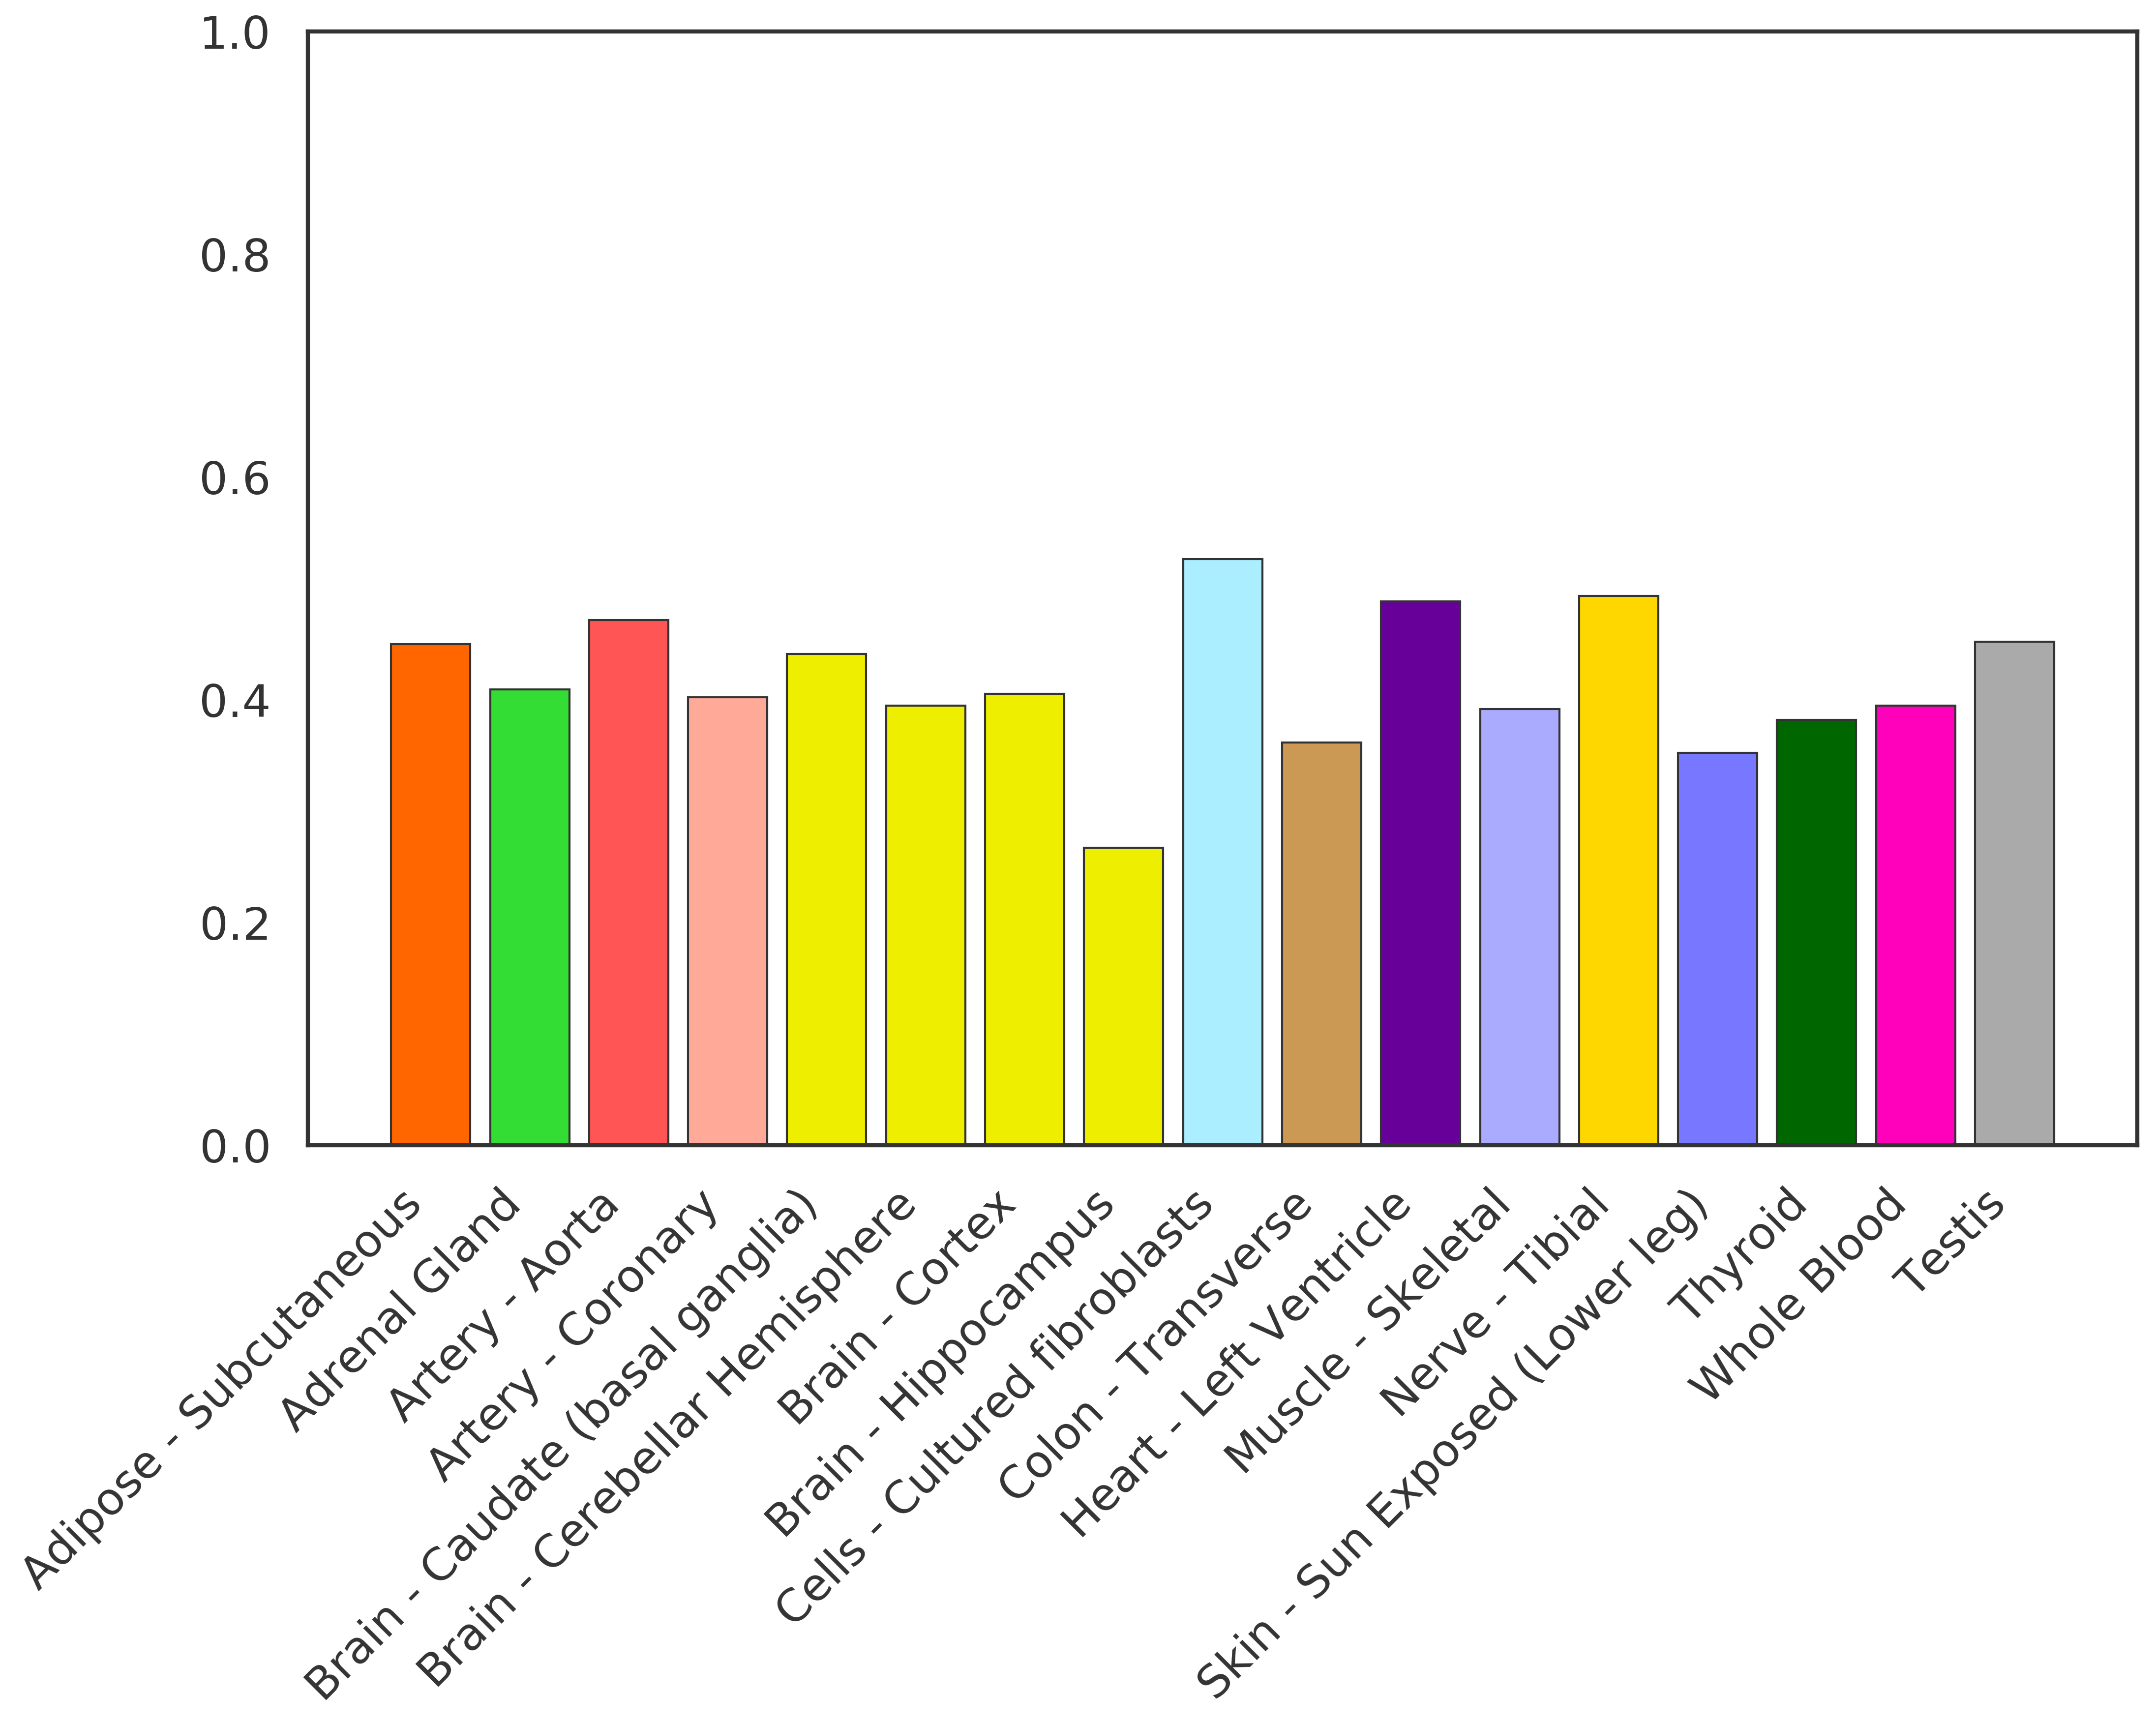

In [22]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

fig = plt.figure(figsize=(16,10))
# ax1  = fig.add_subplot(121)
# x = [x[0] for x in multi_r2]
# y = [x[1] for x in multi_r2]
# ax1.bar(x, y, color=[tissue_colors[i] for i in x])
# ax1.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
# ax1.set_ylabel("% Variance explained (R² @ K=30)")
# ax1.set_ylim(0,1)

ax2  = fig.add_subplot(111)
x = list(tissue_r2_cutoff.keys())
y = [tissue_r2_cutoff[x] for x in tissue_r2_cutoff]
ax2.bar(x, y, color=[tissue_colors[i] for i in x])
ax2.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
# ax2.set_ylabel("% Variance explained (R² @ K=30)")
ax2.set_ylim(0,1)
plt.savefig("KNN_overall_explained_figure.png")
plt.show()

In [7]:
import fastcluster
from scipy.cluster import hierarchy

def calculate_linkage(matrix, rows = False, cols = False):
    if rows:
        data = matrix
        row_linkage = fastcluster.linkage_vector(data.fillna(0).values,
                                   method='single',
                                   metric="euclidean")
        # row_linkage = hierarchy.linkage(data.fillna(0), method="average", metric='euclidean')

        row_dendrogram = hierarchy.dendrogram(row_linkage, no_plot=True, color_threshold=-np.inf)
        row_reordered_ind = row_dendrogram['leaves']

    if cols:
        data = matrix.T
        col_linkage = fastcluster.linkage_vector(data.fillna(0).values,
                                   method='single',
                                   metric="euclidean")
        # col_linkage = hierarchy.linkage(data.fillna(0), method="average", metric='euclidean')
    
        col_dendrogram = hierarchy.dendrogram(col_linkage, no_plot=True, color_threshold=-np.inf)
        col_reordered_ind = col_dendrogram['leaves']
        
    if rows and cols:
        return matrix.iloc[row_reordered_ind, col_reordered_ind]
    if cols:
        return matrix.iloc[:, col_reordered_ind]
    if rows:
        return matrix.iloc[row_reordered_ind, :]

In [8]:
data = calculate_linkage(knn_cov_r2.T, rows=True, cols=True)

In [10]:
covariate_colors = dict()
for k in knn_cov_r2.index: 
    if k in sample_cov_dict:
        covariate_colors[k] = "#ff960d"
    elif k in cov_dict: #subject covariates
        covariate_colors[k] = "#00c465"
    else:
        covariate_colors[k] = "#7223e8"

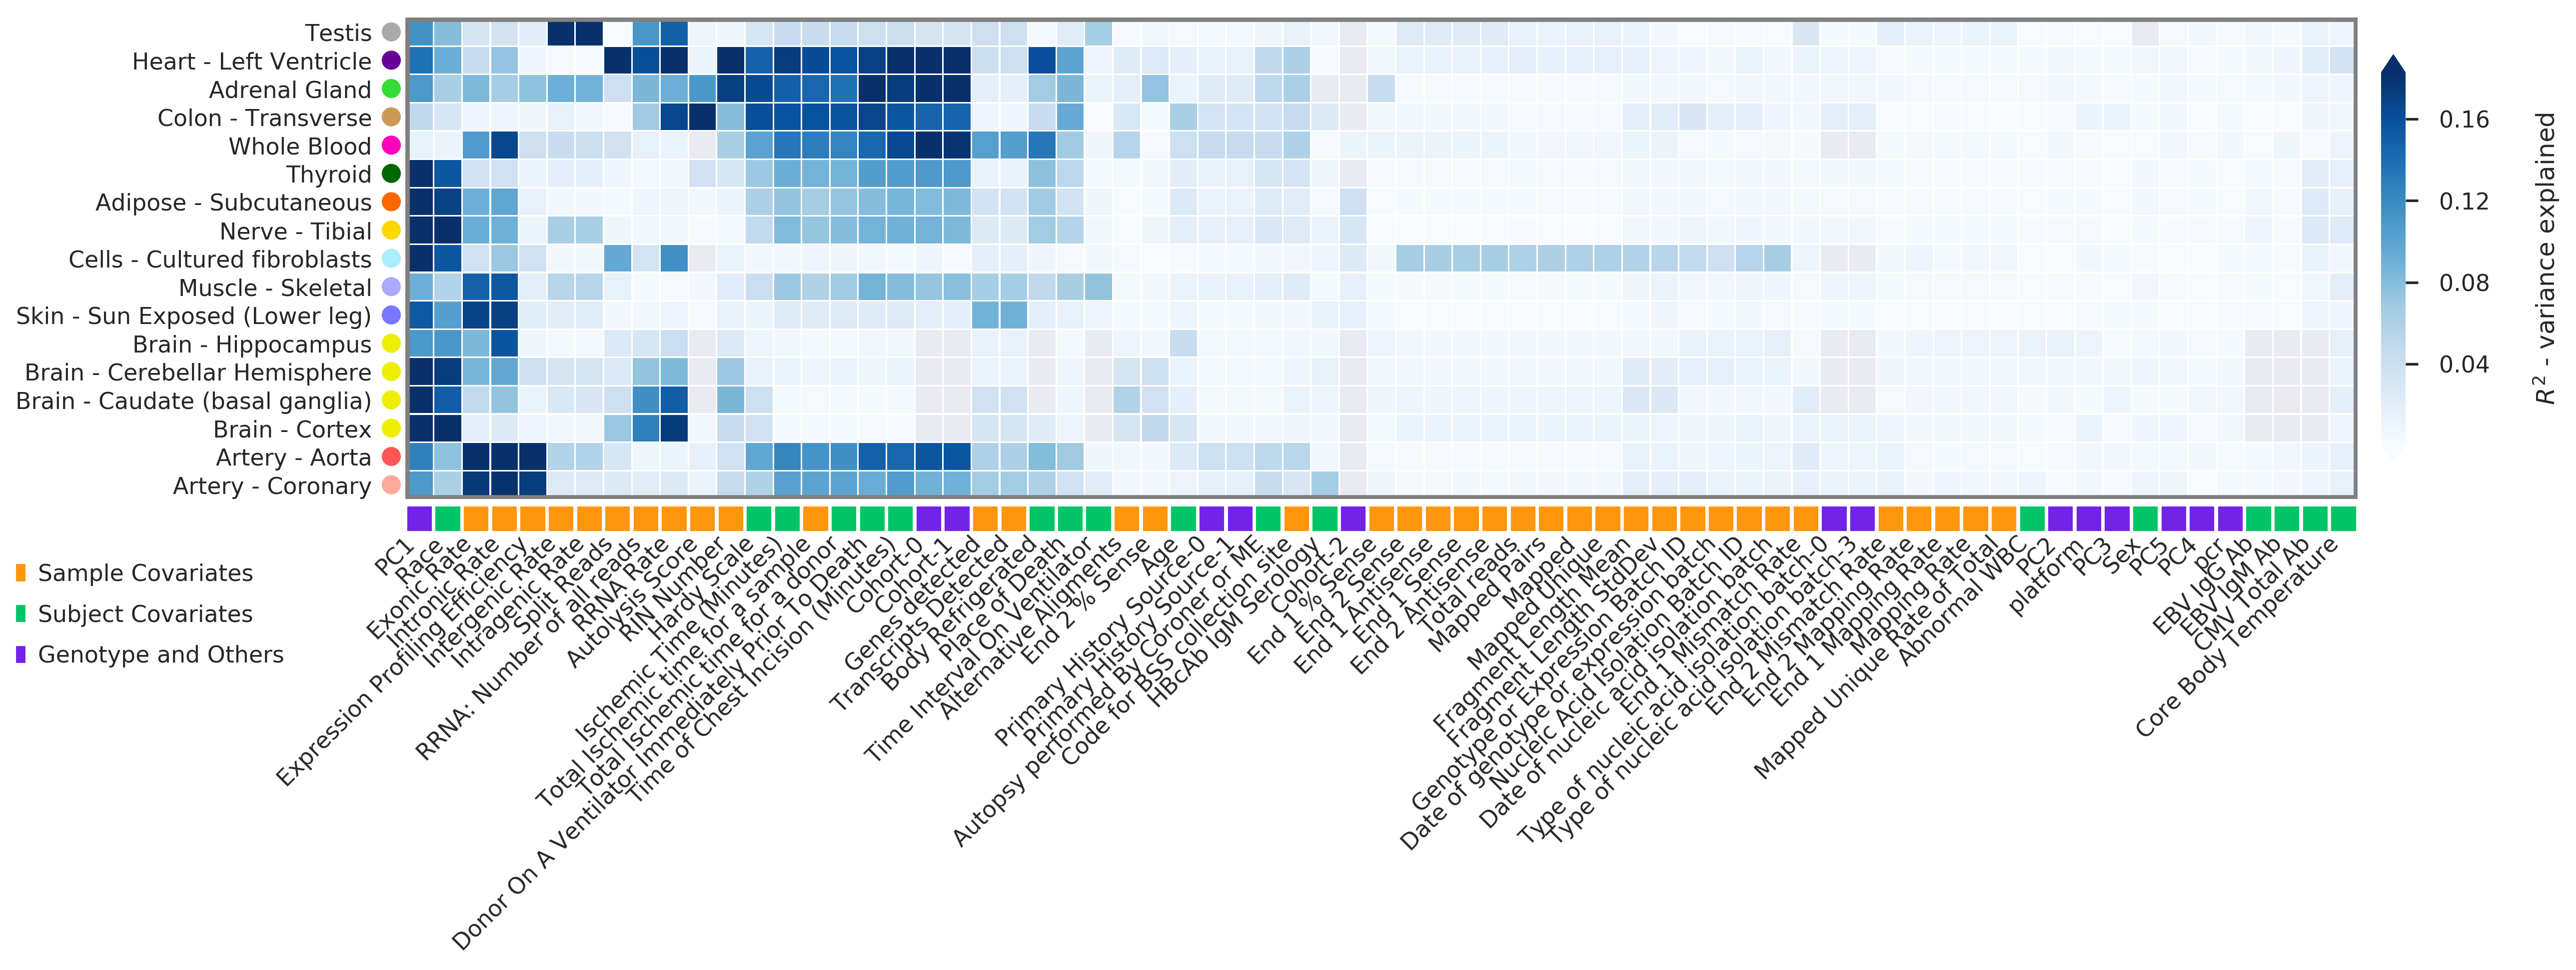

<Figure size 2400x2400 with 0 Axes>

In [19]:
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns; sns.set()

fig = plt.figure(figsize=(20,8), dpi=300)  
ax  = fig.add_subplot(111)
# cbar_ax = fig.add_axes([.905, .3, .05, .3])
cmap = plt.get_cmap("Blues")

mymask = pd.isna(data)

h = sns.heatmap(data,
                cmap=cmap, #"RdBu_r",
                robust=True,
                linewidths=.5,
                cbar_kws={'label': '$R^2$ - variance explained', 'shrink':0.45,
                          'extend':'both',
                          'pad':0.01,
                          'aspect':15},
                ax=ax,
                mask=mymask)

### Use this to change the colorbar ticks and labels
# cbar=plt.colorbar(ax)
# cbar.set_yticklabels(["a","a","a","a","a","a"])
# h.figure.axes[1].set_yticklabels(["-2","-1","0","1","2","3","> 4"])


ax.set_yticklabels(data.index, rotation=90) #, ha='right')
ax.set_xticklabels(data.columns, rotation=90) #, ha='right')

# Countour lines
ax.hlines([ax.get_ylim()[1]]  , *ax.get_xlim(), color='gray', lw=4)
ax.hlines([ax.get_ylim()[0]]  , *ax.get_xlim(), color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-1, ax.get_ylim()[0], color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-1, ax.get_ylim()[1], color='gray', lw=4)

    
my_colors=[tissue_colors[t] for t in data.index]
ax.set_aspect('equal')
for t, X in zip(data.index, ax.get_yticks()):
    ax.add_patch(patches.Circle((-0.5, X), radius=.3,
                                 fill=True,clip_on=False, color=tissue_colors[t]))
    
# labels = ax.get_yticklabels()
# for label in labels:
#     label.set_x(label.get_position()[1] - 0.07 )

ax.set_aspect('equal')
for c, X in zip(data.columns, ax.get_xticks()):
    ax.add_patch(patches.Rectangle((X-0.4, len(data.index)+0.3), width=.8, height=.8,
                                 fill=True, clip_on=False, color=covariate_colors[c]))

labels = ax.get_yticklabels()
ax.set_yticklabels([tissue_names[l.get_text()] for l in labels], rotation=0, ha='right')

labels = ax.get_xticklabels()
new_labels = list()
for l in labels:
    label = l.get_text()
    if "_" in label:
        mylabel = label.split("_")[0]
        if mylabel in cov_dict:
            new_labels.append(cov_dict[mylabel]+"-"+label.split("_")[1])
        elif mylabel in sample_cov_dict:
            new_labels.append(sample_cov_dict[mylabel]+"-"+label.split("_")[1])
    else:
        mylabel = label
        if mylabel in cov_dict:
            new_labels.append(cov_dict[mylabel])
        elif mylabel in sample_cov_dict:
            new_labels.append(sample_cov_dict[mylabel])
        else:
            new_labels.append(mylabel)
ax.set_xticklabels(new_labels, rotation=45, ha='right')

custom_legend = [ patches.Rectangle((0,0), width=1., height=1., facecolor="#ff960d", label='Sample Covariates') ,
                  patches.Rectangle((0,0), width=1., height=1., facecolor="#00c465", label="Subject Covariates"), 
                  patches.Rectangle((0,0), width=1., height=1., facecolor="#7223e8", label="Genotype and Others")]

ax.legend(bbox_to_anchor=(-0.2, -0.35, -0.5, 0.),borderaxespad=0., handles=custom_legend, loc='lower left')

plt.show()
plt.savefig("KNN_covariates_figure.png")